In [112]:
!pip install nixtla

In [113]:
!pip install yfinance

In [114]:
!pip install datasetsforecast

In [115]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from nixtla import NixtlaClient

In [116]:
nixtla_client = NixtlaClient(api_key='nixtla-tok-2WhMO3zBSmvCWqvVBaBAH31mEBTR6YdwLdEurcwldlkVsex1JoxxKPAYYGXjvkPQxp1Ud77q5qvfCw7y')

perionnetwork = "PERI"
start = "2018-01-01"
end = "2023-12-15"

data = yf.download(perionnetwork, start=start, end=end)
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True) 

[*********************100%%**********************]  1 of 1 completed


In [117]:
train_data = data[(data['Date'] >= '2018-01-01') & (data['Date'] <= '2022-12-31')]
test_data = data[(data['Date'] >= '2023-01-01') & (data['Date'] <= '2023-12-15')]

In [118]:
data_forecast = nixtla_client.forecast(
    df=train_data,
    h=len(test_data),
    freq='B',
    level=[90],
    finetune_steps=10,
    model='timegpt-1-long-horizon',
    time_col='Date',
    target_col='Close'
)
data_forecast

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,Date,TimeGPT,TimeGPT-lo-90,TimeGPT-hi-90
0,2023-01-02,25.003696,23.907507,26.099886
1,2023-01-03,24.870344,21.677077,28.063612
2,2023-01-04,24.921295,22.717568,27.125022
3,2023-01-05,24.756176,22.731796,26.780556
4,2023-01-06,24.835632,22.469743,27.201522
...,...,...,...,...
235,2023-11-27,43.664856,32.909647,54.420065
236,2023-11-28,43.594448,33.991264,53.197632
237,2023-11-29,43.335068,33.494706,53.175430
238,2023-11-30,43.236874,33.814866,52.658882


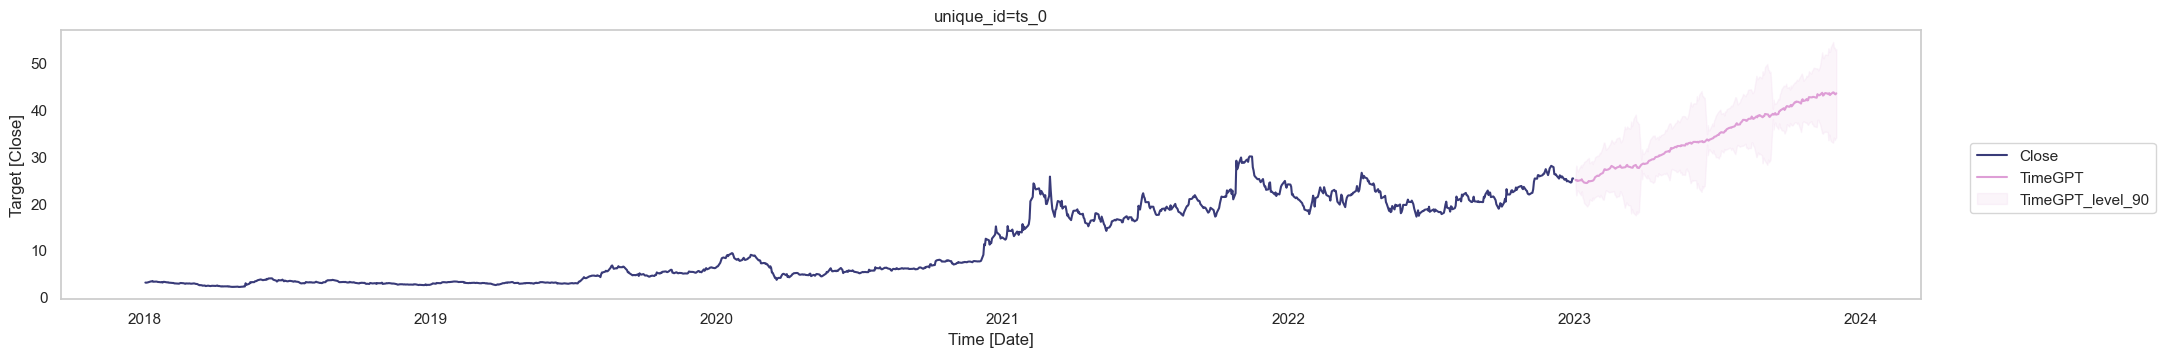

In [119]:
nixtla_client.plot(train_data, data_forecast, models=['TimeGPT'], level=[90], time_col='Date', target_col='Close')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...
INFO:nixtla.nixtla_client:Using the following exogenous variables: Open, High, Low, Adj Close, Volume


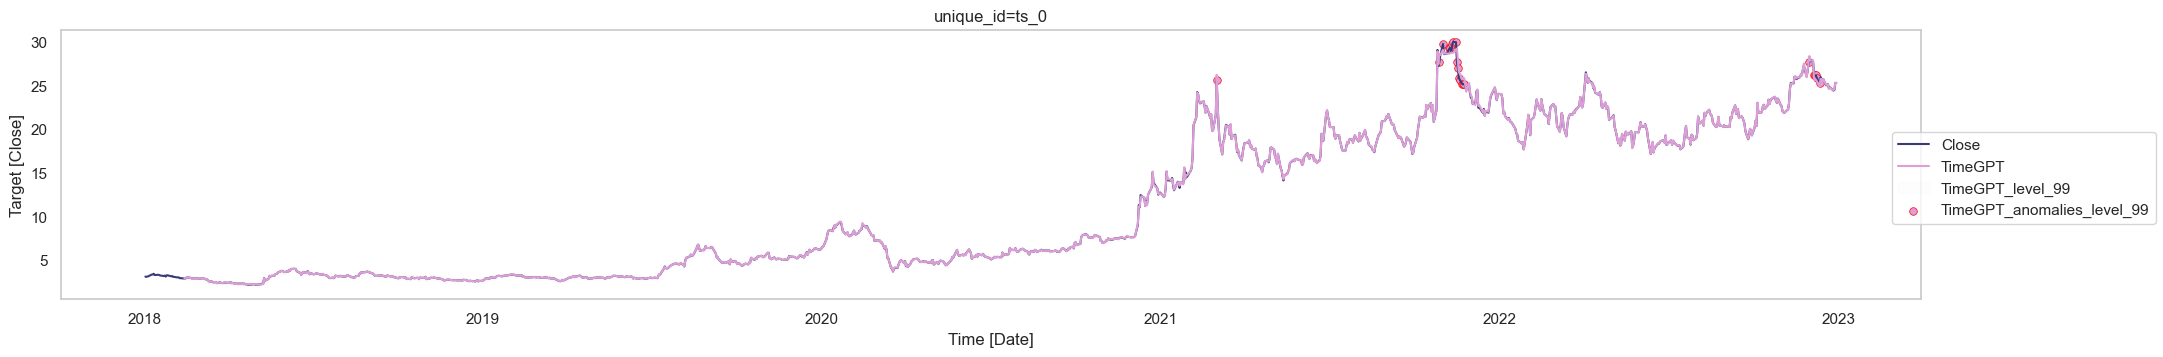

In [120]:
anomalies = nixtla_client.detect_anomalies(train_data, time_col='Date', target_col='Close', freq='B')
nixtla_client.plot(train_data, anomalies, time_col='Date', target_col='Close', plot_anomalies=True)

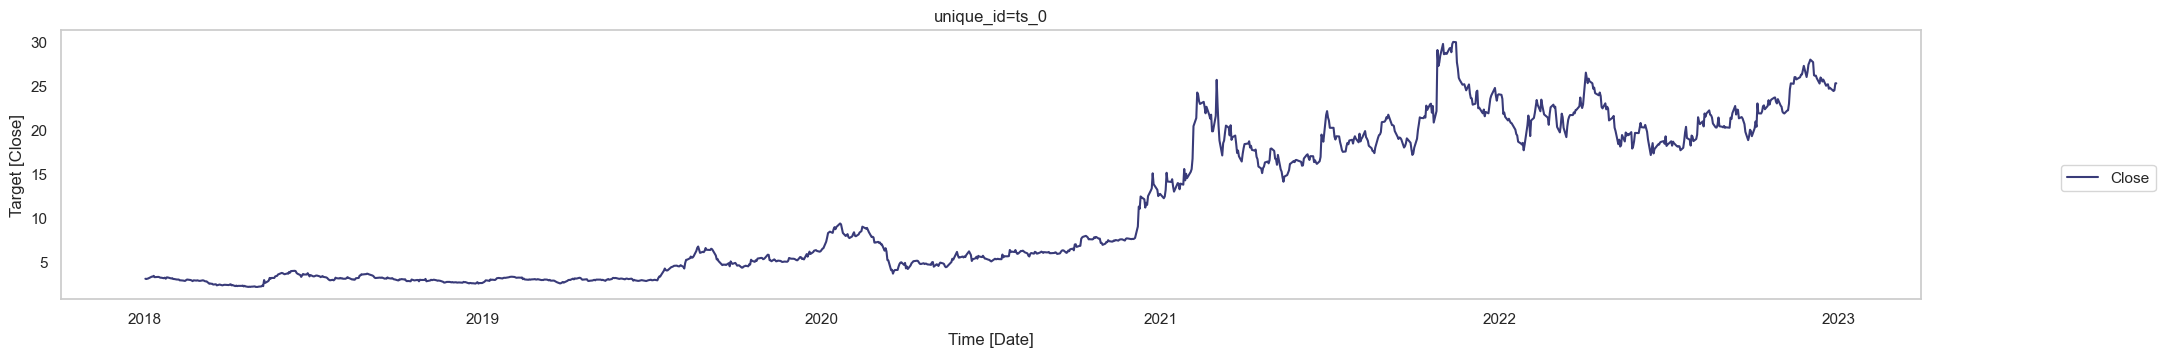

In [121]:
nixtla_client.plot(train_data, time_col='Date', target_col='Close')

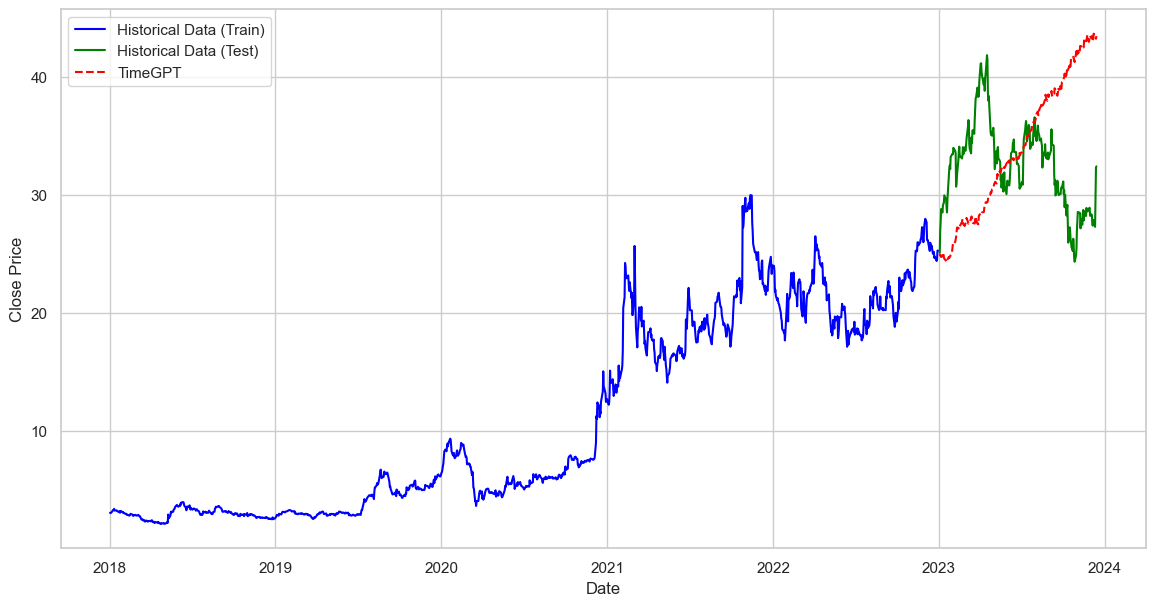

In [122]:
import matplotlib.pyplot as plt

# Визуализация на историческите данни и прогнозата
plt.figure(figsize=(14, 7))
plt.plot(train_data['Date'], train_data['Close'], label='Historical Data (Train)', color='blue')
plt.plot(test_data['Date'], test_data['Close'], label='Historical Data (Test)', color='green')
plt.plot(test_data['Date'], data_forecast['TimeGPT'], label='TimeGPT', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [123]:
# Изчисляване на метриките
rmse = mean_squared_error(test_data['Close'], data_forecast['TimeGPT'], squared=False)
mae = mean_absolute_error(test_data['Close'], data_forecast['TimeGPT'])

# Изчисляване на MAPE
aligned_forecast = data_forecast[data_forecast['Date'].isin(test_data['Date'])].copy()

aligned_forecast.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

mape = np.mean(np.abs((test_data_non_zero_common['Close'].values - aligned_forecast_common['TimeGPT'].values) / test_data_non_zero_common['Close'].values)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

RMSE: 8.492321892601483
MAE: 6.887812431653341
MAPE: 21.814149021586616


In [124]:
highest_forecast_price = data_forecast['TimeGPT'].max()
lowest_forecast_price = data_forecast['TimeGPT'].min()

highest_forecast_date = data.loc[data_forecast['TimeGPT'].idxmax()]['Date']
lowest_forecast_date = data.loc[data_forecast['TimeGPT'].idxmin()]['Date']

print(f"Highest forecasted price: {highest_forecast_price} on {highest_forecast_date}")
print(f"Lowest forecasted price: {lowest_forecast_price} on {lowest_forecast_date}")

Highest forecasted price: 43.66485595703125 on 2018-12-07 00:00:00
Lowest forecasted price: 24.319185256958008 on 2018-01-17 00:00:00
